## Scraping NBA team information from Wikipedia (Revisited)

__Update__ (March 6, 2018): This simple Wikipedia table is the subject of a lot of editing! Somebody modified it again in early February. In this case, the editor felt that US state postal codes would be unfamiliar to international NBA fans. Instead, the table current uses the full name of the US states (and Ontario, in the case of Toronto). The URL below was changed to reflect an historical snapshot of the table prior to this change.

In this notebook, we are going to take another look at scraping [NBA team information from Wikipedia](https://en.wikipedia.org/wiki/National_Basketball_Association#Teams). We will also see how generate a map of NBA arena locations.

In [an earlier notebook](https://github.com/practicallypredictable/posts/blob/master/notebooks/scrape_wikipedia_nba_team_info-part1.ipynb), we scraped the table using the [Requests](http://docs.python-requests.org/en/master/) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) packages.

Unfortunately, somebody modified the table in mid-December. As a result, the original code in that notebook no longer works.

Web content changes all the time, which will occasionally break web scraping code. This is particularly true of Wikipedia, where pages are open to edits by the community.

In this particular case, we could just move on and ignore the table changes. The NBA team data are basically unchanged. We could just use the saved CSV file from the prior scraping. That's a major reason why you should always save the result of web scraping.

On the other hand, I think this is a good opportunity to try to scrape the table in a more robust and general way. You will also see examples of some useful `pandas` techniques to clean up the Wikipedia data. I think you will find these techniques useful in your own sports analytics projects.

I also wanted to do something useful with the Wikipedia information, beyond using it as an example to learn web scraping. Later in this post, we'll discuss why arena location data can be useful in sports analytics. Drawing a map is a perfect way to learn how to start using geographic data in Python. 

### What Changed

The change the person made to the table was relatively simple. This person decided to group together certain cells in the table for the two New York teams (the Knicks and the Nets) and the LA teams (the Clippers and the Lakers). In particular, this person added HTML `rowspan` tags in the City columns, as well as in the Arena column for the LA teams.

Think of `rowspan` and `colspan` tags in an HTML table as being similar to merged cells in a spreadsheet program like Microsoft Excel or Google Sheets.

You can [look at the Wikipedia page prior to the table change here](https://en.wikipedia.org/w/index.php?title=National_Basketball_Association&direction=prev&oldid=815465296), and compare to the current table. Try to use your browser's inspection tools to find the `rowspan` tags that changed.

We want to figure out how to read these merged cells, and "unspan" them to make the table layout simpler.

### Scraping the Table, Again

We are going to use a general approach for scraping HTML tables. This approach will work for Wikipedia and other web pages, and will automatically handle the spanning that broke our original code.

The scraping code is part of the [pracpred package, which you can find on GitHub](https://github.com/practicallypredictable/pracpred) or [find on from PyPI](https://pypi.python.org/pypi/pracpred). You can install the package using the command `pip install pracpred` in your sports analytics environment.

In [1]:
import pracpred.scrape as pps

As usual, we will do our data analysis using [`pandas`](https://pandas.pydata.org/). We will also use the [Matplotlib Basemap](https://matplotlib.org/basemap/) package for plotting a map at the end of this notebook.

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
%matplotlib notebook

In [4]:
from pathlib import Path
import warnings

You'll notice we are going to use the [`warnings`](https://docs.python.org/3/library/warnings.html?highlight=warnings#module-warnings) module from the Python standard library. This is purely cosmetic, because as you'll see toward the end of this notebook, Basemap emits some warning messages that I want to suppress.

In [5]:
PARENT_DIR = Path.cwd().parent

### Getting the Raw HTML Table

f you inspect the HTML for the Wikipedia page, you'll see that it has 5 HTML tables. We really only want the one for the NBA teams. If you inspect this table in your browser, you'll see that it has the HTML tag `<table class="navbox wikitable">`. We can specify this class to make sure we only get back the table we want.

In [6]:
#URL = 'https://en.wikipedia.org/wiki/National_Basketball_Association'
URL = 'https://en.wikipedia.org/w/index.php?title=National_Basketball_Association&oldid=823837048'
NBA_TEAM_INFO = 'navbox wikitable'

In [7]:
USER_AGENT = (
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) ' +
    'AppleWebKit/537.36 (KHTML, like Gecko) ' +
    'Chrome/61.0.3163.100 Safari/537.36'
)

REQUEST_HEADERS = {
    'user-agent': USER_AGENT,
}

Now we can call the scraping code. You can [find the source code on GitHub here](https://github.com/practicallypredictable/pracpred/blob/master/pracpred/scrape/html_tables.py). The package defines two Python classes, `HTMLTables` and `HTMLTable`. The `HTMLTables` `class` is basically a wrapper on top of Requests and BeautifulSoup. This `class` gets and stores the HTML for one or more tables from a URL. The `HTMLTable` `class` has the code to unspan the table and convert it to a `pandas` `DataFrame`.

In [8]:
tables = pps.HTMLTables(URL, table_class=NBA_TEAM_INFO, headers=REQUEST_HEADERS)

In [9]:
len(tables)

1

In [10]:
tables[0].shape

(33, 9)

We got back one table, which has 33 rows and 9 columns. Notice that the table dimensions are the largest number of rows in any column, and the largest number of columns in any row. This is the key to getting the unspanning to work. We want to view the table as a grid of cells to remove the spanning structure.

Now, let's convert the HTML table to a `pandas` `DataFrame`. For this particular table, we want to have any spanned cells repeat the values when we unspan the table.

In [11]:
raw = tables[0].to_df(repeat_span=True)
raw

,0,1,2,3,4,5,6,7,8
0,Division,Team,City,Arena,Capacity,Coordinates,Founded,Joined,Head coach
1,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference
2,Atlantic,Boston Celtics,"Boston, MA",TD Garden,"18,624",42°21′59″N 71°03′44″W﻿ / ﻿42.366303°N 71.06222...,1946,1946,Brad Stevens
3,Atlantic,Brooklyn Nets,"New York City, NY",Barclays Center,"17,732",40°40′58″N 73°58′29″W﻿ / ﻿40.68265°N 73.974689...,1967*,1976,Kenny Atkinson
4,Atlantic,New York Knicks,"New York City, NY",Madison Square Garden,"19,812",40°45′02″N 73°59′37″W﻿ / ﻿40.750556°N 73.99361...,1946,1946,Jeff Hornacek
5,Atlantic,Philadelphia 76ers,"Philadelphia, PA",Wells Fargo Center,"21,600",39°54′04″N 75°10′19″W﻿ / ﻿39.901111°N 75.17194...,1946*,1949,Brett Brown
6,Atlantic,Toronto Raptors,"Toronto, ON",Air Canada Centre,"19,800",43°38′36″N 79°22′45″W﻿ / ﻿43.643333°N 79.37916...,1995,1995,Dwane Casey
7,Central,Chicago Bulls,"Chicago, IL",United Center,"20,917",41°52′50″N 87°40′27″W﻿ / ﻿41.880556°N 87.67416...,1966,1966,Fred Hoiberg
8,Central,Cleveland Cavaliers,"Cleveland, OH",Quicken Loans Arena,"20,562",41°29′47″N 81°41′17″W﻿ / ﻿41.496389°N 81.68805...,1970,1970,Tyronn Lue
9,Central,Detroit Pistons,"Detroit, MI",Little Caesars Arena,"20,491",42°41′49″N 83°14′44″W﻿ / ﻿42.696944°N 83.24555...,1941*,1948,Stan Van Gundy


### Cleaning Up the Table

Now let's clean up the raw information in the table.

#### Column Headers

First, notice that our generic scraping function doesn't know anything about what columns are in the table. We need to create useful column headers.

In [12]:
def setup_columns(raw):
    df = raw.copy()
    df.columns = df.loc[0, :]
    return df.drop(df.index[0])

In [13]:
df = setup_columns(raw)
df

,Division,Team,City,Arena,Capacity,Coordinates,Founded,Joined,Head coach
1,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference,Eastern Conference
2,Atlantic,Boston Celtics,"Boston, MA",TD Garden,"18,624",42°21′59″N 71°03′44″W﻿ / ﻿42.366303°N 71.06222...,1946,1946,Brad Stevens
3,Atlantic,Brooklyn Nets,"New York City, NY",Barclays Center,"17,732",40°40′58″N 73°58′29″W﻿ / ﻿40.68265°N 73.974689...,1967*,1976,Kenny Atkinson
4,Atlantic,New York Knicks,"New York City, NY",Madison Square Garden,"19,812",40°45′02″N 73°59′37″W﻿ / ﻿40.750556°N 73.99361...,1946,1946,Jeff Hornacek
5,Atlantic,Philadelphia 76ers,"Philadelphia, PA",Wells Fargo Center,"21,600",39°54′04″N 75°10′19″W﻿ / ﻿39.901111°N 75.17194...,1946*,1949,Brett Brown
6,Atlantic,Toronto Raptors,"Toronto, ON",Air Canada Centre,"19,800",43°38′36″N 79°22′45″W﻿ / ﻿43.643333°N 79.37916...,1995,1995,Dwane Casey
7,Central,Chicago Bulls,"Chicago, IL",United Center,"20,917",41°52′50″N 87°40′27″W﻿ / ﻿41.880556°N 87.67416...,1966,1966,Fred Hoiberg
8,Central,Cleveland Cavaliers,"Cleveland, OH",Quicken Loans Arena,"20,562",41°29′47″N 81°41′17″W﻿ / ﻿41.496389°N 81.68805...,1970,1970,Tyronn Lue
9,Central,Detroit Pistons,"Detroit, MI",Little Caesars Arena,"20,491",42°41′49″N 83°14′44″W﻿ / ﻿42.696944°N 83.24555...,1941*,1948,Stan Van Gundy
10,Central,Indiana Pacers,"Indianapolis, IN",Bankers Life Fieldhouse,"17,923",39°45′50″N 86°09′20″W﻿ / ﻿39.763889°N 86.15555...,1967,1976,Nate McMillan


#### NBA Conference Information

Next, notice that the Eastern and Western Conference repeat across the entire row. What we want is to remove those rows, and create a new column showing the conference for each team.

In [14]:
def cleanup_nba_conferences(df):
    df['temporary'] = df['Division']
    df = df.set_index('temporary')
    eastern = df.index.get_loc('Eastern Conference')
    western = df.index.get_loc('Western Conference')
    df.loc[eastern+1:western, 'Conference'] = 'Eastern'
    df.loc[western+1:, 'Conference'] = 'Western'
    df = df.drop(df.index[eastern]).drop(df.index[western])
    df['Conference'] = df['Conference'].astype('category')
    df['Division'] = df['Division'].astype('category')
    return df.reset_index(drop=True)

In [15]:
df = cleanup_nba_conferences(df)
df

,Division,Team,City,Arena,Capacity,Coordinates,Founded,Joined,Head coach,Conference
0,Atlantic,Boston Celtics,"Boston, MA",TD Garden,"18,624",42°21′59″N 71°03′44″W﻿ / ﻿42.366303°N 71.06222...,1946,1946,Brad Stevens,Eastern
1,Atlantic,Brooklyn Nets,"New York City, NY",Barclays Center,"17,732",40°40′58″N 73°58′29″W﻿ / ﻿40.68265°N 73.974689...,1967*,1976,Kenny Atkinson,Eastern
2,Atlantic,New York Knicks,"New York City, NY",Madison Square Garden,"19,812",40°45′02″N 73°59′37″W﻿ / ﻿40.750556°N 73.99361...,1946,1946,Jeff Hornacek,Eastern
3,Atlantic,Philadelphia 76ers,"Philadelphia, PA",Wells Fargo Center,"21,600",39°54′04″N 75°10′19″W﻿ / ﻿39.901111°N 75.17194...,1946*,1949,Brett Brown,Eastern
4,Atlantic,Toronto Raptors,"Toronto, ON",Air Canada Centre,"19,800",43°38′36″N 79°22′45″W﻿ / ﻿43.643333°N 79.37916...,1995,1995,Dwane Casey,Eastern
5,Central,Chicago Bulls,"Chicago, IL",United Center,"20,917",41°52′50″N 87°40′27″W﻿ / ﻿41.880556°N 87.67416...,1966,1966,Fred Hoiberg,Eastern
6,Central,Cleveland Cavaliers,"Cleveland, OH",Quicken Loans Arena,"20,562",41°29′47″N 81°41′17″W﻿ / ﻿41.496389°N 81.68805...,1970,1970,Tyronn Lue,Eastern
7,Central,Detroit Pistons,"Detroit, MI",Little Caesars Arena,"20,491",42°41′49″N 83°14′44″W﻿ / ﻿42.696944°N 83.24555...,1941*,1948,Stan Van Gundy,Eastern
8,Central,Indiana Pacers,"Indianapolis, IN",Bankers Life Fieldhouse,"17,923",39°45′50″N 86°09′20″W﻿ / ﻿39.763889°N 86.15555...,1967,1976,Nate McMillan,Eastern
9,Central,Milwaukee Bucks,"Milwaukee, WI",Bradley Center,"18,717",43°02′37″N 87°55′01″W﻿ / ﻿43.043611°N 87.91694...,1968,1968,Joe Prunty,Eastern


#### City and Postal Code

Next, we want to split the city and the postal code into two separate columns.

To do this, we need to use [`pandas` string-handling methods](https://pandas.pydata.org/pandas-docs/stable/text.html).

In [16]:
def split_city_postal(df):
    df['Postal'] = df['City'].str.rsplit(',', n=1).str.get(1).str.replace('.', '').str.strip()
    df['City'] = df['City'].str.rsplit(',', n=1).str.get(0)
    return df

In [17]:
df = split_city_postal(df)
df.head()

,Division,Team,City,Arena,Capacity,Coordinates,Founded,Joined,Head coach,Conference,Postal
0,Atlantic,Boston Celtics,Boston,TD Garden,"18,624",42°21′59″N 71°03′44″W﻿ / ﻿42.366303°N 71.06222...,1946,1946,Brad Stevens,Eastern,MA
1,Atlantic,Brooklyn Nets,New York City,Barclays Center,"17,732",40°40′58″N 73°58′29″W﻿ / ﻿40.68265°N 73.974689...,1967*,1976,Kenny Atkinson,Eastern,NY
2,Atlantic,New York Knicks,New York City,Madison Square Garden,"19,812",40°45′02″N 73°59′37″W﻿ / ﻿40.750556°N 73.99361...,1946,1946,Jeff Hornacek,Eastern,NY
3,Atlantic,Philadelphia 76ers,Philadelphia,Wells Fargo Center,"21,600",39°54′04″N 75°10′19″W﻿ / ﻿39.901111°N 75.17194...,1946*,1949,Brett Brown,Eastern,PA
4,Atlantic,Toronto Raptors,Toronto,Air Canada Centre,"19,800",43°38′36″N 79°22′45″W﻿ / ﻿43.643333°N 79.37916...,1995,1995,Dwane Casey,Eastern,ON


#### Arena Latitude and Longitude

Lastly, we need to clean up the arena latitude and longitude. This is a little tricky, since there is a lot of content packed into the Coordinates column in the `DataFrame`. Let's focus on one row to see what's going on.

In [18]:
row = list(df.loc[df['Team'] == 'Boston Celtics', 'Coordinates'].str.split('/'))
row

[['42°21′59″N 71°03′44″W\ufeff ',
  ' \ufeff42.366303°N 71.062228°W\ufeff ',
  ' 42.366303; -71.062228\ufeff (Boston Celtics)']]

There are 3 elements per row, with different formats for the latitude and longitude. In case you were wondering, the `\ufeff` appearing in the text strings are a special [Unicode](https://en.wikipedia.org/wiki/Byte_order_mark) character. We are going to ignore the first two elements and just get the third.

We need to split this third element into latitude and longitude by the semi-colon (;) and extract the numbers. Again, we will use `pandas` string-handling methods, along with [regular expressions](https://docs.python.org/3/howto/regex.html). Regular expressions are a very general way to find and extract text in many computer languages, including Python. In this particular case, the regular expression just gets numbers with a decimal point, potentially starting with a negative sign.

In [19]:
def get_arena_lat_lon(df):
    df['Coordinates'] = df['Coordinates'].str.split('/').str.get(2).str.split(';')
    df['Latitude'] = df['Coordinates'].str.get(0).astype(float)
    df['Longitude'] = df['Coordinates'].str.get(1).str.extract('(-+[\d]*\.[\d]*)', expand=False).astype(float)
    return df

In [20]:
df = get_arena_lat_lon(df)
df.head()

,Division,Team,City,Arena,Capacity,Coordinates,Founded,Joined,Head coach,Conference,Postal,Latitude,Longitude
0,Atlantic,Boston Celtics,Boston,TD Garden,"18,624","[ 42.366303, -71.062228﻿ (Boston Celtics)]",1946,1946,Brad Stevens,Eastern,MA,42.366303,-71.062228
1,Atlantic,Brooklyn Nets,New York City,Barclays Center,"17,732","[ 40.68265, -73.974689﻿ (Brooklyn Nets)]",1967*,1976,Kenny Atkinson,Eastern,NY,40.682650,-73.974689
2,Atlantic,New York Knicks,New York City,Madison Square Garden,"19,812","[ 40.750556, -73.993611﻿ (New York Knicks)]",1946,1946,Jeff Hornacek,Eastern,NY,40.750556,-73.993611
3,Atlantic,Philadelphia 76ers,Philadelphia,Wells Fargo Center,"21,600","[ 39.901111, -75.171944﻿ (Philadelphia 76ers)]",1946*,1949,Brett Brown,Eastern,PA,39.901111,-75.171944
4,Atlantic,Toronto Raptors,Toronto,Air Canada Centre,"19,800","[ 43.643333, -79.379167﻿ (Toronto Raptors)]",1995,1995,Dwane Casey,Eastern,ON,43.643333,-79.379167


#### Putting It All Together

Now we'll just put all these steps into one function. This function will combine all the steps, do a few more simple cleanups, and drop columns that we don't need at the end. We also want to save the final, cleaned-up results.

In [21]:
def wiki_teams_info(raw):
    df = setup_columns(raw)
    df = cleanup_nba_conferences(df)
    df = split_city_postal(df)
    df = get_arena_lat_lon(df)
    df['Capacity'] = df['Capacity'].str.replace(',', '').astype(int)
    df['Founded'] = df['Founded'].str.replace('*', '').astype(int)
    df['Joined'] = df['Joined'].str.replace('*', '').astype(int)
    cols = [
        'Team',
        'Conference',
        'Division',
        'City',
        'Postal',
        'Arena',
        'Capacity',
        'Latitude',
        'Longitude',
        'Founded',
        'Joined',
        'Head coach',
    ]
    return df[cols].reset_index(drop=True)

In [22]:
df = wiki_teams_info(raw)
df

,Team,Conference,Division,City,Postal,Arena,Capacity,Latitude,Longitude,Founded,Joined,Head coach
0,Boston Celtics,Eastern,Atlantic,Boston,MA,TD Garden,18624,42.366303,-71.062228,1946,1946,Brad Stevens
1,Brooklyn Nets,Eastern,Atlantic,New York City,NY,Barclays Center,17732,40.682650,-73.974689,1967,1976,Kenny Atkinson
2,New York Knicks,Eastern,Atlantic,New York City,NY,Madison Square Garden,19812,40.750556,-73.993611,1946,1946,Jeff Hornacek
3,Philadelphia 76ers,Eastern,Atlantic,Philadelphia,PA,Wells Fargo Center,21600,39.901111,-75.171944,1946,1949,Brett Brown
4,Toronto Raptors,Eastern,Atlantic,Toronto,ON,Air Canada Centre,19800,43.643333,-79.379167,1995,1995,Dwane Casey
5,Chicago Bulls,Eastern,Central,Chicago,IL,United Center,20917,41.880556,-87.674167,1966,1966,Fred Hoiberg
6,Cleveland Cavaliers,Eastern,Central,Cleveland,OH,Quicken Loans Arena,20562,41.496389,-81.688056,1970,1970,Tyronn Lue
7,Detroit Pistons,Eastern,Central,Detroit,MI,Little Caesars Arena,20491,42.696944,-83.245556,1941,1948,Stan Van Gundy
8,Indiana Pacers,Eastern,Central,Indianapolis,IN,Bankers Life Fieldhouse,17923,39.763889,-86.155556,1967,1976,Nate McMillan
9,Milwaukee Bucks,Eastern,Central,Milwaukee,WI,Bradley Center,18717,43.043611,-87.916944,1968,1968,Joe Prunty


In [23]:
OUTPUT_DIR = PARENT_DIR / 'data' / 'scraped'
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
csvfile = OUTPUT_DIR.joinpath('wiki-nba_team_info.csv')
df.to_csv(csvfile, index=False)

You can use these HTML scraping tools and techniques in your own sports analytics projects. But we're not done yet.

### A Map of NBA Arenas

We haven't done anything useful with the NBA team data from Wikipedia. One nice thing we can do is to draw a map of NBA arena locations using the latitude and longitude information.

There's a more practical use for this arena data. Most serious [strength of schedule](https://en.wikipedia.org/wiki/Strength_of_schedule) analysis in the NBA looks at road games, rest and distance traveled. In a future post, we'll see how to incorporate this geographic information to estimate travel distance between games.

#### Another HTML Table to Scrape

We are going to use Python's [Basemap package](https://basemaptutorial.readthedocs.io/en/latest/) to draw a map of North America with NBA arenas. We are also going to going to fill in the U.S. states having NBA arenas using a different color for each NBA Division. Sorry Toronto and Washington fans. Any coloring for Washington, D.C. wouldn't be visible anyway, and this example won't fill in the province of Ontario.

In order to do this coloring, we need to use [shapefiles](https://basemaptutorial.readthedocs.io/en/latest/shapefile.html). These files contain information about the shapes of various geographic features (in this case, U.S. states). We will overlay these shapes on our map filled with the correct color. The shapefiles we will use come from the [U.S. Census Bureau](https://www.census.gov/geo/maps-data/data/prev_cartbndry_names.html).

In order to use these particular shapefiles, we need to be able to move between state names and postal abbreviations. Our arena data has only the postal abbreviations, and the shapefiles use state names.

There are plenty of ways to get this information (including typing it in to a Python program yourself). However, since this technical guide is about scraping HTML tables, we can use it as another opportunity to scrape a Wikipedia table.

Let's scrape [Wikipedia's list of U.S. state abbreviations](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations).

In [24]:
ABBR_URL = 'https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations'

We can use the same HTML table scraping function as before. In this case, we want to use a table class of `'sortable'` to get the right table.

In [25]:
abbr_tables = pps.HTMLTables(ABBR_URL, headers=REQUEST_HEADERS, table_class='sortable')

In [26]:
len(abbr_tables)

1

In [27]:
abbr_df = abbr_tables[0].to_df()
abbr_df

,0,1,2,3,4,5,6,7,8,9
0,"Codes: ISO ISO 3166 codes (2-letter, 3-l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Name and status of region,NaN,ISO,ANSI,NaN,USPS,USCG,GPO,AP,Other abbreviations
2,,,,,,,,NaN,NaN,NaN
3,United States of America,Federal state,US USA 840,US,00,,,U.S.,U.S.,U.S.A.
4,Alabama,State,US-AL,AL,01,AL,AL,Ala.,Ala.,
5,Alaska,State,US-AK,AK,02,AK,AK,Alaska,Alaska,Alas.
6,Arizona,State,US-AZ,AZ,04,AZ,AZ,Ariz.,Ariz.,Az.
7,Arkansas,State,US-AR,AR,05,AR,AR,Ark.,Ark.,
8,California,State,US-CA,CA,06,CA,CF,Calif.,Calif.,"Ca., Cal."
9,Colorado,State,US-CO,CO,08,CO,CL,Colo.,Colo.,Col.


#### Cleaning an Ugly Table

This is a relatively ugly table. Notice that many of the cells are blank. One of the reasons I wanted to use this example is to show how this general web scraping framework works, even for ugly tables.

In this case, we just want the name, status and USPS columns. We can also filter out any obsolete postal codes.

In [28]:
def usps_abbrs(raw):
    df = raw.drop(raw.index[:4]).reset_index(drop=True)
    df = df.iloc[:, [0, 1, 5]]
    df.columns = ['Name', 'Status', 'USPS']
    df = df.loc[(df['USPS'] != '') & (~df['Status'].str.contains('Obsolete')), ['Name', 'Status', 'USPS']]
    return df.reset_index(drop=True)

In [29]:
usps_df = usps_abbrs(abbr_df)
usps_df.tail(20)

,Name,Status,USPS
42,Tennessee,State,TN
43,Texas,State,TX
44,Utah,State,UT
45,Vermont,State,VT
46,Virginia,State (Commonwealth),VA
47,Washington,State,WA
48,West Virginia,State,WV
49,Wisconsin,State,WI
50,Wyoming,State,WY
51,American Samoa,Insular area (Territory),AS


This simple table is just what we need. Now, we can build a function which will return the postal abbreviation given the state name.

In [30]:
def state_abbr_mapper(usps_df):
    name_usps = usps_df[['Name', 'USPS']].set_index('Name').to_dict(orient='Index')
    def inner(name):
        return name_usps[name]['USPS']
    return inner

In [31]:
name2abbr = state_abbr_mapper(usps_df)

In [32]:
name2abbr('Alabama')

'AL'

Take another look at what this function does. We used an inner function, which we return. This inner function "remembers" the `DataFrame` which was passed in to the outer function. It will be very easy to use this simple function as a wrapper to the `DataFrame` in our map-drawing code below.

#### Drawing the Map

Now we can start putting the pieces of the map together.

First, we need a function to create a Basemap of the lower 48 U.S. states, along with portions of Canada and Mexico.

In [33]:
def draw_basemap():
    """Lambert Conformal map of lower 48 U.S. states with portions of Canada and Mexico."""
    m = Basemap(
        llcrnrlon=-119,
        llcrnrlat=22,
        urcrnrlon=-64,
        urcrnrlat=49,
        projection='lcc',
        lat_1=32,
        lat_2=45,
        lon_0=-95,
    )
    m.fillcontinents(color='lightgray')
    return m

#### Reading the Shapefiles

Next, we read in our shapefiles for the U.S. states.

In [34]:
def read_shape_files(m):
    """ Get U.S. state shape boundaries."""
    # Shapefiles downloaded from https://www.census.gov/geo/maps-data/data/prev_cartbndry_names.html
    MAP_DATA_DIR = PARENT_DIR / 'data'
    SHAPEFILE = MAP_DATA_DIR.joinpath('st99_d00')
    return m.readshapefile(
        shapefile=str(SHAPEFILE),
        name='states',
        drawbounds=True,
        color='white',
        linewidth=1,
    )

#### Making a Colormap for NBA Divisions

Next, we create a colormap with a distinct color for each of the NBA Divisions.

In [35]:
def make_colormap(divisions, colormap='Set3'):
    """Create colormap with distinct value for each NBA division."""
    cmap = plt.get_cmap(colormap, len(divisions))  
    return {div: cmap(divisions.index(div))[:3] for div in divisions}

We want to assign a color to each state that has an NBA arena. Of course, we can't use the U.S. state shapefiles for Toronto.

In [36]:
def get_state_colors(df):
    colors = make_colormap(list(df['Division'].str.strip().unique()))
    state_color = {}
    for abbr in list(df['Postal'].str.strip().unique()):
        div = list(df.loc[df['Postal'] == abbr, 'Division'].unique())
        assert len(div) == 1 # there can only be one Division applicable for teams from one U.S. state
        div = str(div[0])
        color = colors[div]
        state_color[abbr] = rgb2hex(color)
    return state_color

Next, we need to get the information from the shapefile for each U.S. state. This is where we need to use our function to look up the postal abbreviation given a U.S. state name from the shapefile.

In [37]:
def get_state_polygons(m):
    state_polygons = {}
    for info, shape in zip(m.states_info, m.states):
        abbr = name2abbr(info['NAME'])
        if abbr in state_polygons:
            state_polygons[abbr].append(Polygon(shape, True))
        else:
            state_polygons[abbr] = [Polygon(shape, True)]
    return state_polygons

#### Putting It All Together and Drawing the Map

To draw the map, we need to perform the following steps:

- Create the Basemap;
- Read in the state shapefiles and assign the colors for the states that need to be filled in;
- Fill in the states with the correct colors
- Draw markers for the arenas using the latitude and longitude information
- Create text labels for the arenas using the team names
- Show the map

As I mentioned above, Basemap may emit some warnings when you run this code. The warnings I get are harmless, and I've filtered them out using the `warnings` module. You can run this code without the `warnings` module if you want, and the map should still be fine.

In [38]:
def draw_nba_map(df):
    """Draw map with locations of NBA arenas."""
    
    fig, ax = plt.subplots(figsize=(12,8))
    m = draw_basemap()
    state_shapes = read_shape_files(m)
    state_polygons = get_state_polygons(m)
    state_colors = get_state_colors(df)
    
    # Color in states (skip Ontario and Washington, DC)
    for abbr in state_colors:
        if abbr not in ['ON', 'DC']:
            ax.add_collection(PatchCollection(
                state_polygons[abbr],
                facecolor=state_colors[abbr],
                edgecolor='white',
                linewidth=1,
                zorder=2)
            )

    # Display markers and labels for arenas
    cities = set()
    for _, row in df.iterrows():
        city = row['City']
        x, y = m(row['Longitude'], row['Latitude'])
        m.plot(x=x, y=y, color='black', marker='o', markersize=5)
        team = row['Team'].split()[-1]
        
        # If a city has already been plotted, offset the text so labels don't overlap
        if city in cities:
            label_x = x+40000
            label_y = y+40000
        else:
            label_x = x+40000
            label_y = y-40000
            cities.add(city)
        plt.text(x=label_x, y=label_y, s=team, fontsize='smaller')

    # Remove the box surrounding the plot
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()

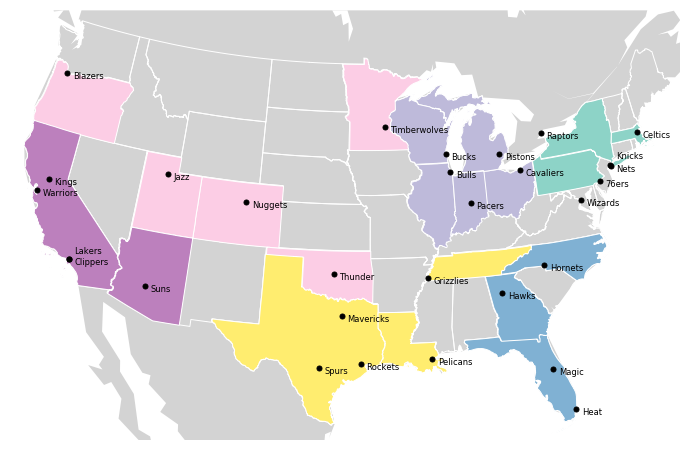

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    draw_nba_map(df)

This simple example only scratches the surface of what you can do with geographical data in Python.